In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from keras.metrics import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import os
import PIL
import time
from IPython import display

In [5]:
root_path = "images/"
root_path = pathlib.Path(root_path)

In [7]:
# Prepraing data
batch_size = 32

data = tf.keras.utils.image_dataset_from_directory(
    directory = root_path,
    label_mode = None,
    batch_size = batch_size,
    image_size = (64,64)
)
    

Found 63565 files belonging to 1 classes.


In [8]:
data

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

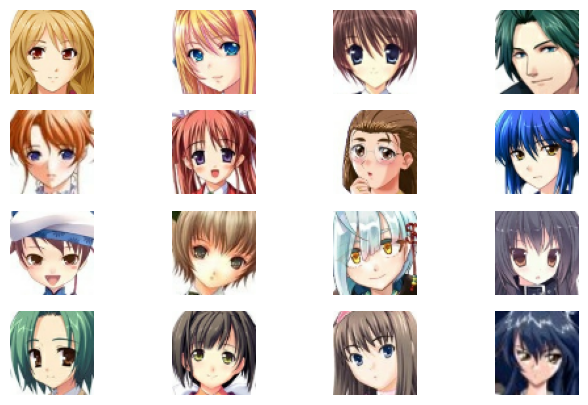

In [11]:
# Lets see some images of the datasets
plt.figure(figsize=(8,5))
for images in data.take(1):
    for i in range(16):
        ax = plt.subplot( 4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')

In [12]:
# normalizing the input image to the range [-1, 1]
data = data.map(lambda d : ((d-127.5)/127.5))
data

<MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [13]:
def Discriminator():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(64,64,3)))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.2))
    discriminator.add(Dense(1, activation="sigmoid"))
    return discriminator

D_model = Discriminator()
D_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                        

In [15]:
# Discriminator
#def Discriminator():
#    discriminator = Sequential()
#    discriminator.add(Conv2D(filters=64, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU", input_shape=(64,64,3)))
#    discriminator.add(BatchNormalization())
#    discriminator.add(Dropout(0.2))

#    discriminator.add(Conv2D(filters=128, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU"))
#    discriminator.add(BatchNormalization())
#    discriminator.add(Dropout(0.2))

#    discriminator.add(Conv2D(filters=256, kernel_size=3, strides=(2,2), padding="same", activation="LeakyReLU"))
#    discriminator.add(BatchNormalization())
#    discriminator.add(Dropout(0.2))

#    discriminator.add(Flatten())
#    discriminator.add(Dropout(0.2))
#    discriminator.add(Dense(units=1, activation="sigmoid"))

#    return discriminator

#D_model = Discriminator()
#D_model.summary()


In [14]:
# optimizer
D_optm = Adam(1e-4)

In [16]:
latent_dim = 100

In [17]:
# Build the Generator function
def Generator(latent_dim):
    generator = Sequential()
    generator.add(Dense(256 * 4 * 4, input_dim=latent_dim))
    generator.add(Reshape((4, 4, 256)))
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    
    generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh"))
    return generator


# a summary of the Generetor
G_model = Generator(latent_dim)
G_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)       

In [18]:
# optimizer
G_optm = Adam(1e-4)

In [19]:
# creating random noise
random_noise = tf.random.normal([1,latent_dim])

In [20]:
# feeding random noise to Genereator
G_output_on_random_noise = G_model(random_noise, training=False)


(-0.5, 63.5, 63.5, -0.5)

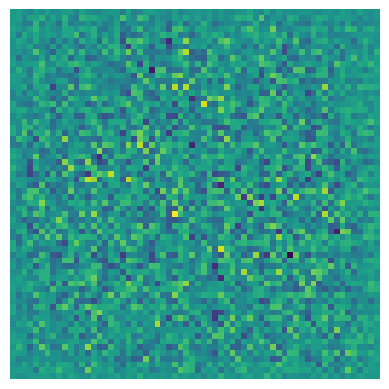

In [21]:
# showing the image output of G_model
plt.imshow(G_output_on_random_noise[0, :, :, 0])
plt.axis("off")

In [22]:
# feeding the output of Generator to Discriminator
D_output_on_random_noise = D_model(G_output_on_random_noise)
print(D_output_on_random_noise)

tf.Tensor([[0.49969012]], shape=(1, 1), dtype=float32)


In [23]:
# The code of this cell is from keras sample.
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [24]:
# loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [25]:
# Defining GAN model
model = GAN(discriminator=D_model, generator=G_model, latent_dim=latent_dim)

In [28]:
# Compiling GAN Model
model.compile(d_optimizer=D_optm, g_optimizer=G_optm, loss_fn=loss_fn)


In [29]:
# number of epochs
epochs = 50
# Fitting the GAN model
history = model.fit(data, epochs=epochs)

Epoch 1/50
1987/1987 [==============================] - 115s 56ms/step - d_loss: -0.9006 - g_loss: 323.0868
Epoch 2/50
1987/1987 [==============================] - 132s 66ms/step - d_loss: 0.4017 - g_loss: 12.9907
Epoch 3/50
1987/1987 [==============================] - 120s 61ms/step - d_loss: 0.3972 - g_loss: 6.5708
Epoch 4/50
1987/1987 [==============================] - 117s 59ms/step - d_loss: 0.3293 - g_loss: 4.2795
Epoch 5/50
1987/1987 [==============================] - 119s 60ms/step - d_loss: 0.2906 - g_loss: 4.0503
Epoch 6/50
1987/1987 [==============================] - 119s 60ms/step - d_loss: 0.2470 - g_loss: 3.8572
Epoch 7/50
1987/1987 [==============================] - 120s 60ms/step - d_loss: 0.2359 - g_loss: 3.5597
Epoch 8/50
1987/1987 [==============================] - 119s 60ms/step - d_loss: 0.2231 - g_loss: 3.5138
Epoch 9/50
1987/1987 [==============================] - 119s 60ms/step - d_loss: 0.2228 - g_loss: 3.3338
Epoch 10/50
1987/1987 [============================

In [30]:
# creating a random nosie to feed it to the trained Generator model
noise = tf.random.normal([32, 100])
# Generatine new images using the trained Generator model 
generated_images = G_model(noise, training=False)


In [31]:
# converting the input image to the range [0, 255]
generated_images1 = (generated_images+127.5)*127.5


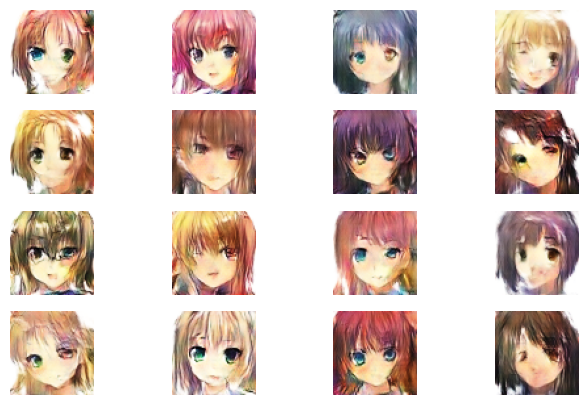

In [32]:
plt.figure(figsize=(8, 5))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_images1[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()

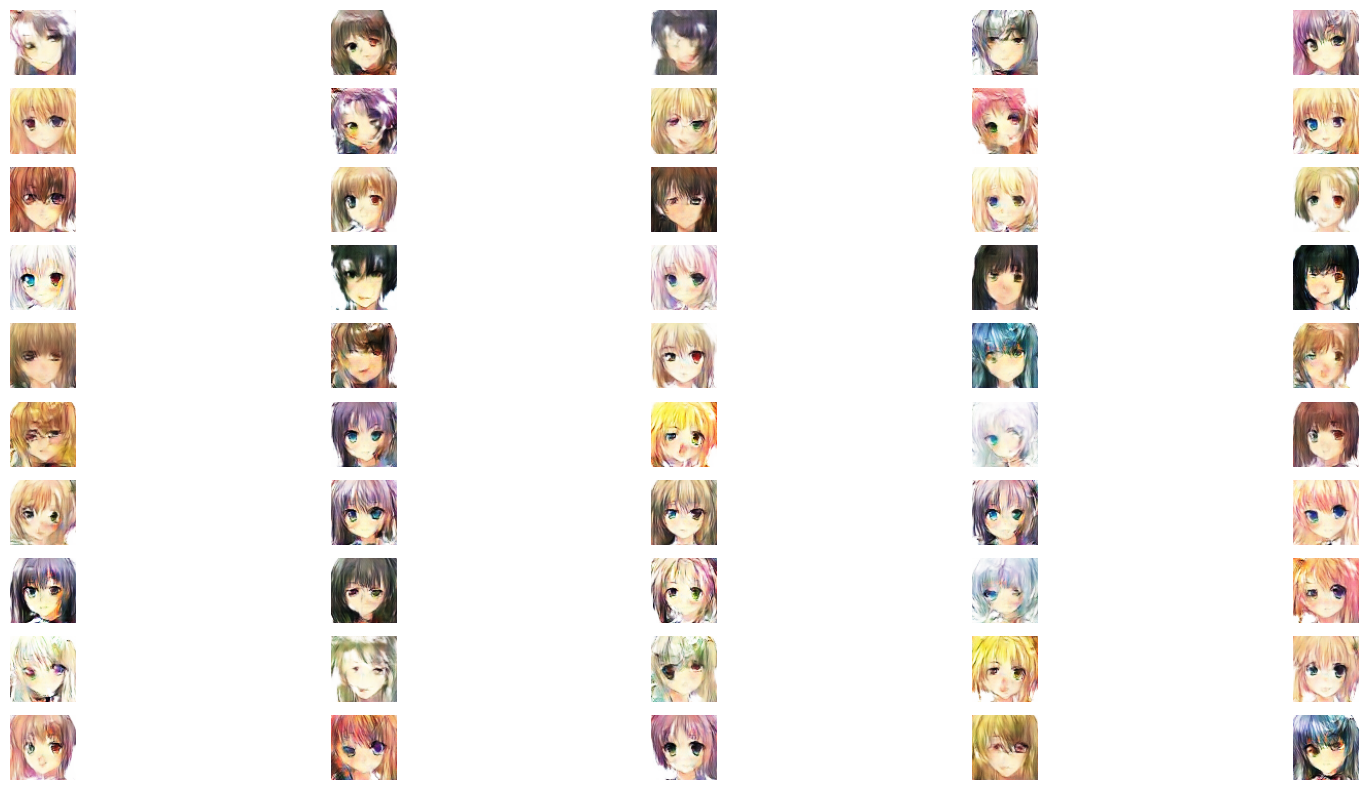

In [33]:
# Adjusting this for 50 images
noise = tf.random.normal([50, 100])  # Batch size is now 50

# Generating new images using the trained Generator model
generated_images = G_model(noise, training=False)

# Converting the generated images to the range [0, 255]
generated_images1 = (generated_images + 1) / 2 * 255  # Correct normalization for tanh (-1,1) to (0,255)

# Setting up the plot for 50 images in a 10x5 grid
plt.figure(figsize=(20, 10))  # Adjusted figure size for better visibility
for i in range(50):  # Looping through all 50 images
    ax = plt.subplot(10, 5, i + 1)
    plt.imshow(generated_images1[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()


In [34]:
# Save the weights of the Generator
G_model.save_weights('generator_weights.h5')

# Save the weights of the Discriminator
D_model.save_weights('discriminator_weights.h5')
